# TO DO
- MORE Visualizations : Choosing the number of topics, results graph...
- Where to include optimal number of topics, coherence, perplexity y unique words?
- Interpretation of Lambda (l)
- Intepretation of perplexity and sparsity and loglikelihood (include formulas)
- Choosing the best model (grid search based on loglikelihood?)
- Give each topic a "name"
- Add coherence to the metrics????
- 'make pretty'

# LDA analysis

In [53]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=5, suppress=True)
import pandas as pd
# data: 20 news groups

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
import random
from sklearn.feature_extraction.text import CountVectorizer

import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
pyLDAvis.enable_notebook()

[nltk_data] Downloading package punkt to /Users/ribarragi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ribarragi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ribarragi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ribarragi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ribarragi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Data preprocessing

In [129]:
# Read in data
df = pd.read_csv('../data/data_tweet.csv')

# RIG (made some changes to stopwords)
# modify default stop words
add_stopwords = set(['rt','train','southern','east','derailment','norfolk','palestine','february','u','ohio', 'amp'])
remove_stopwords = set(["no", "not", "nor", "against", "aren't", "couldn't", "didn't", 
                                                   "doesn't", "don't", "haven't", "hadn't", "hasn't", "isn't", "mightn't",
                                                   "mustn't", "needn't", "shouldn't", "wasn't", "weren't", "wouldn't"])
# remove stopwords (not impacting sentiment analysis) and punctuations
stop_words = set(stopwords.words('english')) - remove_stopwords
stop_words = set(stopwords.words('english')).union(add_stopwords)
# stop_words = set(stopwords.words('english')).union(add_stopwords_2)
tokenizer = RegexpTokenizer(r'\w+')


# normalize pos tags
lemmatizer = WordNetLemmatizer()

def pos_tagger(nltk_tag):
  if nltk_tag.startswith('J'):
      return wordnet.ADJ
  elif nltk_tag.startswith('V'):
      return wordnet.VERB
  elif nltk_tag.startswith('N'):
      return wordnet.NOUN
  elif nltk_tag.startswith('R'):
      return wordnet.ADV
  else:         
      return None

# lemmatize each token with pos tag
def lemma_token(row):
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), row))
  lemmatized = []
  for word, tag in wordnet_tagged:
    if tag is None:
        # if there is no available tag, just append the original token
        lemmatized.append(word)
    else:       
        # else use the pos tag to lemmatize the token
        lemmatized.append(lemmatizer.lemmatize(word, tag))
  return lemmatized


# RIG (edit: added http://)
# remove urls
df['Message_no_url'] = df['MESSAGE'].apply(lambda x: " ".join([word for word in x.split(" ") if not(word.startswith(("https://", 'http://')))]))


# tokenize MESSAGE and remove stopwords
df['Text'] = df['Message_no_url'].map(tokenizer.tokenize)
df['Text'] = df['Text'].apply(lambda x : nltk.pos_tag([item.lower() for item in x if item.lower() not in stop_words]))

# apply lemmatization and reset index
df['Text'] = df['Text'].apply(lambda row : lemma_token(row))
df = df.reset_index(drop=True)

# join words
df['T_text'] = df['Text'].apply(lambda row : " ".join(row))

In [3]:
# number of documents (tweets) in our data
len(df)

85220

In [ ]:
# # We first used a random sample to test this
# sample_size = 10000
# random.seed(1)
# # We will use a random sample of 10k tweets to test
# idx_sample = random.sample(range(len(df.T_text)), sample_size)
# # sample_data is a list of strings, each string is a tweet. ssample_Data is length 10k
# sample_data = [df.T_text[i] for i in idx_sample]
# len(sample_data)

In [4]:
# take only the text
sample_data = df.T_text.tolist()

## Vectorization

We use CountVectorizer to get term frequencies.

In [5]:
# We could cap the size of the vocab to vocab_size
# If not capped, we have 48k words
max_vocabulary = 15000

# We can also set options to only keep words that appear in at least this percentage of documents
# - min_df = 2 # words in less than 2 documents we discard them
# And we can choose to only keep words that appear in at most this percentage of documents:
# - max_df = 0.95 # words that appear in more than 95% of documents, we discard them
# Finally, we can set max_features, to keep only the most frequently occuring words
# - max_features = max_vocabulary # after I do the max_df, min_df and stopwords filetrs, I look at how many words I have left: if its greater than
# max_features, I only keep the most popular. BUT, if the words left after the 3 filters is less than max_features, then it will be ignored. 


# tf_vectorizer = CountVectorizer(max_df=0.95,
#                                 min_df=2,
#                                 stop_words='english',
#                                 max_features=max_vocabulary)

# tf_vectorizer = CountVectorizer(stop_words='english')

# We capped the number of words to 15k and the min doc frequency
tf_vectorizer = CountVectorizer(min_df = 2, max_features=max_vocabulary)

# tf: term frequency vectorizer

# the fitting is learning the vocabulary: goes thru all the data and know the words it needs to keep track of
# transform: Ive done the fitting, Ill go back to data points and convert each one into a feat vector representation using the vocab i learnt during fitting
tf_fit = tf_vectorizer.fit(sample_data)
tf = tf_vectorizer.fit_transform(sample_data)


In [6]:
# size of the matrix (documents, words)
tf.toarray().shape

(85220, 15000)

In [7]:
# seems like the highest term-doc freq is 10
max_freq = tf.toarray().max()
max_freq

10

In [73]:
# which doc / word combination has highest values?
max_freq_idx = list(np.argwhere(tf.toarray()==max_freq)[0])
max_freq_doc, max_freq_word = max_freq_idx
# to print out the vocabulary in the doc-word freq matrix
tf_vectorizer.get_feature_names_out()[max_freq_word]
# In which document is this word?
sample_data[max_freq_doc]

'trump state go trump trump trump trump trump trump trump trump trump'

In [ ]:
tf[0].toarray()

# I can index in to the zeroeth row of the matrix and convert into an array, I am anazlizing just the zeroeth row:
# feature vector representation for the zeroeth document: 
# We should be able to write code to know what word corresponds each non zero number there

# tf_vectorizer.get_feature_names_out()[(tf[0].toarray() != 0)[0]] # LIKE THIS!

# run a for loop that goes thru the entries, and check to which indeces this corresponds in the vocabulary

array([[0, 0, 0, ..., 0, 0, 0]])

The fitting procedure determines the every topic's distribution over words; this information is stored in the `components_` attribute. There's a catch: we actually have to normalize to get the probability distributions (without this normalization, instead what the model has are pseudocounts for how often different words appear per topic).

We now fit an LDA model to the data.

In [12]:
# Now LDA. This will take a while ong

num_topics = 4

lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

LatentDirichletAllocation(n_components=4, random_state=0)

In [13]:
lda.components_.shape
# The shaope of this is 16 by 1000, 10 topics and 1000 words
# These are not probability distributions yet

(4, 15000)

In [29]:
lda.components_  

array([[ 16.11285, 319.16088,   0.25549, ...,   0.25001,   0.25001,
          0.25001],
       [ 17.45323, 720.37464,   0.25503, ...,  11.24819,  11.24819,
         11.24819],
       [  0.28027, 139.28358,   0.25415, ...,   0.25011,   0.25011,
          0.25011],
       [ 60.15364, 182.1809 ,   6.23532, ...,   0.25169,   0.25169,
          0.25169]])

In [14]:
# If we access: sum ACROSS COLUMNS (get rid of columns), I get 6 numbers: a sum for each row.
# They dont sum uop to 1, because not probability distributions

# .components_ is a raw count histogram, but why are there fractions?
# Because of how it works: when it estimates how much a word belongs to a topic it does a prob assignment, not a deterministic assignment.
lda.components_.sum(axis=1)

array([264743.16727, 213299.88075, 353547.17579, 210579.77618])

In [30]:
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])

# we get the topic-word distribution matrix for the LDA model.  Each value represents the probability of each word occuring in that topic. 
# The higher the value of a word in a topic, the more strongly the word is associated with that topic

In [46]:
topic_word_distributions.shape

(4, 15000)

In [45]:
print(topic_word_distributions[0])
# lets look at 0th topic, it is saying that the 0th word appears 0.00006, word 1 appears with prob 0.00121

[0.00006 0.00121 0.      ... 0.      0.      0.     ]


In [37]:
# # we can sort the probability by big to small
# # for each topic, listing top 20 most popular words (by probability)

# num_top_words = 20

# def print_top_words(topic_word_distributions, num_top_words, vectorizer):
#     vocab = vectorizer.get_feature_names_out()
#     num_topics = len(topic_word_distributions)
#     print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
#     print()

#     for topic_idx in range(num_topics):
#         print('[Topic ', topic_idx, ']', sep='')
#         # This is the interesting part: take the topic_word_distributions only for the topic_idxth topic, and get the indexes sorted from highest to lowest
#         sort_indices = np.argsort(-topic_word_distributions[topic_idx])
#         # then for the range 0,num_words, print the vocab of each of the words and its entry in the topic_word_distribution matrix
#         for rank in range(num_top_words):
#             word_idx = sort_indices[rank]
#             print(vocab[word_idx], ':',
#                   topic_word_distributions[topic_idx, word_idx])
#         print()

# print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)

In [28]:
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.117772  0.039317       1        1  33.758269
0      0.158341 -0.028672       2        1  25.439415
1     -0.133837 -0.190190       3        1  20.511758
3     -0.142276  0.179544       4        1  20.290558, topic_info=           Term         Freq        Total Category  logprob  loglift
13647     trump  8369.000000  8369.000000  Default  30.0000  30.0000
2452        ceo  4905.000000  4905.000000  Default  29.0000  29.0000
3790     derail  8840.000000  8840.000000  Default  28.0000  28.0000
1090    another  5759.000000  5759.000000  Default  27.0000  27.0000
11592    safety  6474.000000  6474.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
13457      town  1019.707343  2757.467019   Topic4  -5.3200   0.6002
7926       live   917.976849  2044.281326   Topic4  -5.4251   0.7944
3790     derail  1108.150593  8840.677081   Topic4  -5.2369  -0.4817
11693       say  1059.011880  8758.041167   Topic4  -5.2822  -0.5176
4008   disaster   925.007364  5779.998506   Topic4  -5.4175  -0.2373

[305 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
164        2  0.000499      20
164        3  0.999400      20
197        3  0.998648     212
242        3  0.992799      28
567        3  0.998071  aboard
...      ...       ...     ...
14766      1  0.434129   wreck
14766      2  0.355808   wreck
14766      3  0.159121   wreck
14766      4  0.051032   wreck
14902      1  0.992895    yost

[572 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

In [48]:
# We want to know, for each tweet, what fraction is explained by each of the topics
doc_topic_matrix = lda.transform(tf)
# Ill get a low dimensional version of the data, the document topic matrix (10, 10)
# each of the 10,000 represented as a distribution over 10 different topics

In [49]:
doc_topic_matrix.shape

(85220, 4)

In [85]:
sample_data[3]

'nicksortor break state sue explosion aim force railroad pay environmental cleanup economic damage'

In [84]:
df.MESSAGE.iloc[3]

'RT @nicksortor 🚨 #BREAKING: The State of Ohio is SUING Norfolk Southern over the East Palestine train explosion, aiming to FORCE the railroad to pay for environmental cleanup and economic damage.'

In [50]:
# The topic distribution of the 0th document is very small except for 0.96288 fior index 7
# We saw from above, topic 7 is about religion, and we can check that document 0 is about religion
doc_topic_matrix[0]

# Note: for GMM when you do the .predict, itll give you k probabilites that sum to 1. 
# predict_proba of GMM 
# here: ... gives you a proba distr:
# INTERPRETARATION DIFFERENT

# FOR LDA: document can consist of a bunch of words, and different fraction of the words are truly in different topics: we get mixed membership, words are allowed to e in different topics
# GMM: the above doesnt hold

array([0.87253, 0.01727, 0.09306, 0.01714])

In [51]:
# here we can take some tweets and say:this is the topic it belongs to...

In [52]:
doc_topic_matrix[0].sum()

1.0

## Split: media, public, govt

### To do
Present these results and then tweak:
- Adjust count vectorizer parameters to get better sparsity (0.2-0.8)

In [164]:
data_media = df.query('IS_MEDIA == 1')
data_govt = df.query('IS_GOVT == 1')
data_people = df.query('IS_PEOPLE == 1')

In [165]:
def parse_lda(dataframe, max_voc, min_df, num_topics):
  '''Outputs...
  Parameters: 
    list_documents:list of strings, contains documents to be analyzed
    max_voc:int, the max size of vocab allowed
    min_df: int, minimum document frequency, i.e., keep words that appear in at least this number of documents
    '''
  sample_data = dataframe.T_text.tolist()
  max_vocabulary = max_voc
  tf_vectorizer = CountVectorizer(min_df = min_df, max_features=max_voc)
  tf_fit = tf_vectorizer.fit(sample_data)
  tf = tf_vectorizer.fit_transform(sample_data)
  lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
  lda.fit(tf)

  return tf, tf_vectorizer, tf_vectorizer.get_feature_names_out(), lda, sample_data

In [169]:
# we are getting the term frequency, ..., the vocabulary ordered alphabetically, fitted lda and the data used.
tf, tf_vectorizer, vocab, lda, data = parse_lda(data_media, max_voc = 3800, min_df = 2, num_topics = 4)

In [170]:
print(f'Size of the ... (tweets, words in vocabulary): {tf.toarray().shape}')

Size of the ... (tweets, words in vocabulary): (7406, 3800)


In [171]:
# Metrics part 1

# 1. Sparsity
# How sparse is this document?
# We are taking the non zero entries in the doc-word frequency matrix
# Sparsity (%) = (# of zero elements in tf / total # of elements in tf) x 100

sparsity_media = ((tf.todense() > 0).sum() / tf.todense().size)*100
print(f'Sparsity: {sparsity_media}')


#LOOK: to icnrease sparsity, we can increase min_df (can be integer or float)
# we can also lower max_features
# we can also reduce stop words

Sparsity: 0.2971594866182469


In [172]:
def most_frequent(tf, vocab, data):
  #highest frequency word
  max_freq = tf.toarray().max()
  # which doc / word combination has highest values?
  max_freq_idx = list(np.argwhere(tf.toarray()==max_freq)[0])
  max_freq_doc, max_freq_word = max_freq_idx
  # to print out the vocabulary in the doc-word freq matrix
  # vocab[max_freq_word]
  # In which document is this word?
  # sample_data[max_freq_doc]
  print(f'The most repeated word in a single tweet is {vocab[max_freq_word]}, and it is repeated {max_freq} times in the tweet: {data[max_freq_doc]}')
  

In [173]:
most_frequent(tf, vocab, data)

The most repeated word in a single tweet is get, and it is repeated 4 times in the tweet: get rid safety rule get get rid bank safety rule get svb signature


In [174]:
topic_word = np.array([row / row.sum() for row in lda.components_])

In [175]:
topic_word.shape


(4, 3800)

In [176]:
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.170431 -0.089653       1        1  26.656149
2      0.158806 -0.149856       2        1  26.454255
0      0.085323  0.164567       3        1  25.840036
1     -0.073698  0.074942       4        1  21.049560, topic_info=           Term        Freq       Total Category  logprob  loglift
595         ceo  647.000000  647.000000  Default  30.0000  30.0000
558         car  478.000000  478.000000  Default  29.0000  29.0000
986      derail  829.000000  829.000000  Default  28.0000  28.0000
3681      water  421.000000  421.000000  Default  27.0000  27.0000
3019     senate  332.000000  332.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
2429      order   85.019251  267.634547   Topic4  -5.3556   0.4115
1637  hazardous   94.331142  555.053187   Topic4  -5.2516  -0.2140
2322        new   80.973021  283.158324   Topic4  -5.4043   0.3064
619    chemical   89.094741  814.414232   Topic4  -5.3087  -0.6545
2841     report   81.482943  380.448192   Topic4  -5.3980   0.0173

[270 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
25        2  0.996306           20
40        2  0.980491          212
130       2  0.991563       aboard
146       1  0.104861  accountable
146       3  0.188749  accountable
...     ...       ...          ...
3751      1  0.007925       worker
3751      2  0.285318       worker
3751      3  0.110957       worker
3751      4  0.586487       worker
3788      3  0.991653         yost

[436 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

In [177]:
def tweet_topic(dataframe, lda, tf, tweet_no):
  tweet_topic_matrix = lda.transform(tf)
  print(f'{dataframe.MESSAGE.iloc[tweet_no]}')
  print(f'{tweet_topic_matrix[tweet_no]}')

In [178]:
tweet_topic(data_media, lda, tf, 14)

Ohio filed a lawsuit against railroad Norfolk Southern to make sure it pays for the cleanup and environmental damage caused by a fiery train derailment last month. https://t.co/2iybJ3ySje
[0.9455  0.01808 0.0183  0.01812]


In [179]:
# Metrics part 2


# 2. Loglikelihood
loglikelihood_media = lda.score(tf)
perplexity_media = lda.perplexity(tf)

print(f'Loglikelihood: {loglikelihood_media}')
print(f'Perplexity: {perplexity_media}')

# INTERPRETATION MISSING



Loglikelihood: -598000.972311989
Perplexity: 1086.7800853503707


In [ ]:
# Choose optimal model

# Visualize keyowrds for topics???

## GOVT


In [197]:
tf, tf_vectorizer, vocab, lda, data = parse_lda(data_govt, max_voc = 800, min_df = 2, num_topics = 4)

In [198]:
print(f'Size of the ... (tweets, words in vocabulary): {tf.toarray().shape}')

Size of the ... (tweets, words in vocabulary): (376, 848)


In [199]:
# Metrics part 1

# 1. Sparsity
# How sparse is this document?
# We are taking the non zero entries in the doc-word frequency matrix
# Sparsity (%) = (# of zero elements in tf / total # of elements in tf) x 100

sparsity_govt = ((tf.todense() > 0).sum() / tf.todense().size)*100
print(f'Sparsity: {sparsity_govt}')


#OJO: to icnrease sparsity, we can increase min_df (can be integer or float)
# we can also lower max_features
# we can also reduce stop words

Sparsity: 1.444889100762746


In [200]:
most_frequent(tf, vocab, data)

The most repeated word in a single tweet is update, and it is repeated 3 times in the tweet: update ohioag file civil lawsuit united state district court northern district today full update previous update information


topic_word = np.array([row / row.sum() for row in lda.components_])
topic_word.shape


In [201]:

pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.020538  0.055345       1        1  27.142608
1     -0.132251 -0.097154       2        1  25.236641
2     -0.004523  0.113011       3        1  25.091852
3      0.157312 -0.071202       4        1  22.528899, topic_info=         Term       Freq      Total Category  logprob  loglift
128       ceo  29.000000  29.000000  Default  30.0000  30.0000
259       epa  34.000000  34.000000  Default  29.0000  29.0000
687      shaw  17.000000  17.000000  Default  28.0000  28.0000
54       alan  15.000000  15.000000  Default  27.0000  27.0000
634  resident  30.000000  30.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
658    safety   8.299702  57.870314   Topic4  -4.8689  -0.4516
263   epwcmte   5.921882  13.567311   Topic4  -5.2065   0.6614
62   american   5.444792  11.848202   Topic4  -5.2905   0.7129
360   hearing   5.471275  13.555625   Topic4  -5.2857   0.5831
596       put   5.268983  11.014747   Topic4  -5.3233   0.7530

[272 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1         1  0.878748        000
15        2  0.938117         24
28        1  0.131082   accident
28        2  0.065541   accident
28        3  0.458786   accident
...     ...       ...        ...
835       1  0.547132     worker
835       2  0.234485     worker
835       3  0.156323     worker
838       3  0.784528      wreck
844       2  0.879699  yesterday

[394 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [206]:
tweet_topic(data_govt, lda, tf, 14)

The disaster in East Palestine clearly demonstrates the need for more federal oversight on rail and transportation companies. Our economy depends on infrastructure and railways, and it is in the best interest of all of us to have safe and reliable service. https://t.co/I5xnAn87k2
[0.01006 0.09555 0.88417 0.01022]


In [202]:
# Metrics part 2


# 2. Loglikelihood
loglikelihood_govt = lda.score(tf)
loglikelihood_govt = lda.perplexity(tf)

print(f'Loglikelihood: {loglikelihood_govt}')
print(f'Perplexity: {loglikelihood_govt}')

# INTERPRETATION MISSING


Loglikelihood: -32159.344147288863
Perplexity: 816.8465370366005


## People

In [208]:
tf, tf_vectorizer, vocab, lda, data = parse_lda(data_people, 12000, 2, num_topics = 4)

In [210]:
print(f'Size of the ... (tweets, words in vocabulary): {tf.toarray().shape}')

Size of the ... (tweets, words in vocabulary): (77438, 12000)


In [209]:
# Metrics part 1

# 1. Sparsity
# How sparse is this document?
# We are taking the non zero entries in the doc-word frequency matrix
# Sparsity (%) = (# of zero elements in tf / total # of elements in tf) x 100

sparsity_people = ((tf.todense() > 0).sum() / tf.todense().size)*100
print(f'Sparsity: {sparsity_people}')


#OJO: to icnrease sparsity, we can increase min_df (can be integer or float)
# we can also lower max_features
# we can also reduce stop words

Sparsity: 0.09589262808095939


In [150]:
most_frequent(tf, vocab, data)

The most repeated word in a single tweet is trump, and it is repeated 10 times in the tweet: trump state go trump trump trump trump trump trump trump trump trump


In [151]:
topic_word = np.array([row / row.sum() for row in lda.components_])
topic_word.shape

(4, 15000)

In [211]:
#12000
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.120229 -0.111512       1        1  31.863366
3     -0.047036  0.198256       2        1  27.970858
2      0.180722  0.001626       3        1  24.165724
0     -0.253914 -0.088369       4        1  16.000052, topic_info=          Term         Freq        Total Category  logprob  loglift
870    another  5467.000000  5467.000000  Default  30.0000  30.0000
3042   derails  4092.000000  4092.000000  Default  29.0000  29.0000
1961       ceo  4172.000000  4172.000000  Default  28.0000  28.0000
11380      via  4599.000000  4599.000000  Default  27.0000  27.0000
1354     biden  5234.000000  5234.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
9324       say  1911.837430  7424.646601   Topic4  -4.3486   0.4758
10813    toxic  1997.191193  9427.907090   Topic4  -4.3049   0.2806
10443     tell   908.434510  2658.464420   Topic4  -5.0927   0.7588
2327   company   942.704936  3947.030343   Topic4  -5.0557   0.4006
4915    health   774.436146  2027.909740   Topic4  -5.2523   0.8700

[305 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
130        1  0.000553       20
130        2  0.996786       20
130        4  0.002214       20
143        3  0.996298     2015
159        2  0.997730      212
...      ...       ...      ...
11912      2  0.290672     year
11912      3  0.528394     year
11912      4  0.014892     year
11935      2  0.007436  youtube
11935      4  0.991461  youtube

[576 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

In [212]:
#15000
# pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

In [ ]:
tweet_topic(data_people, lda, tf, 14)

In [213]:
# Metrics part 2


# 2. Loglikelihood
loglikelihood_people = lda.score(tf)
perplexity_people = lda.perplexity(tf)

print(f'Loglikelihood: {loglikelihood_people}')
print(f'Perplexity: {perplexity_people}')

# INTERPRETATION MISSING

Loglikelihood: -6901292.724032542
Perplexity: 1745.8362936854046


# Until here, the rest need editing and deleting !!!

## cut

In [117]:
word1 = 'year'
word2 = 'team'

word1_column_idx = tf_vectorizer.vocabulary_[word1]
word2_column_idx = tf_vectorizer.vocabulary_[word2]

In [ ]:
np.array(tf.todense())

In [ ]:
tf[:, word1_column_idx].toarray()

In [ ]:
documents_with_word1 = (tf[:, word1_column_idx].toarray().flatten() > 0)

In [ ]:
documents_with_word2 = (tf[:, word2_column_idx].toarray().flatten() > 0)

In [ ]:
documents_with_both_word1_and_word2 = documents_with_word1 * documents_with_word2

In [ ]:
documents_with_both_word1_and_word2

Next, we compute the log of the conditional probability of word 1 appearing given that word 2 appeared, where we add in a little bit of a fudge factor in the numerator (in this case, it's actually not needed but some times you do have two words that do not co-occur for which you run into a numerical issue due to taking the log of 0).

In [ ]:
eps = 0.1
np.log2((documents_with_both_word1_and_word2.sum() + eps) / documents_with_word2.sum())

In [29]:
# compute log of prob of see one word given you see another, using count vectorizer!
# Same content as in hw , but with a different tool
# This uses np.arrays instead of counters. Needs to kep track of the indexes.
# Understad how countvectorizer works

def prob_see_word1_given_see_word2(word1, word2, vectorizer, eps=0.1):
    word1_column_idx = vectorizer.vocabulary_[word1]
    word2_column_idx = vectorizer.vocabulary_[word2]
    documents_with_word1 = (tf[:, word1_column_idx].toarray().flatten() > 0)
    documents_with_word2 = (tf[:, word2_column_idx].toarray().flatten() > 0)
    documents_with_both_word1_and_word2 = documents_with_word1 * documents_with_word2
    return np.log2((documents_with_both_word1_and_word2.sum() + eps) / documents_with_word2.sum())

In [ ]:
type(word1), type(word2)

## Topic coherence

The below code shows how one implements the topic coherence calculation from lecture.

In [ ]:
# In the cell below, vectorizer.get_feature_names() is just tokenizing the text, 
# eliminating stopwords, eliminating some other words, and then giving you back
# a list of the tokens in string format

In [30]:
# topic coherence

def compute_average_coherence(topic_word_distributions, num_top_words, vectorizer, verbose=True):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    average_coherence = 0
    # foor loop thru different topics, for each topic double nested for loop, going thru each entry, ordering matters
    # make sure words arent the same, then compute the log(prob)
    # add a bunhc of them and divide by total number of topics
    for topic_idx in range(num_topics):
        if verbose:
            print('[Topic ', topic_idx, ']', sep='')
        
        sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
        coherence = 0.
        for top_word_idx1 in sort_indices[:num_top_words]:
            word1 = vocab[top_word_idx1]
            for top_word_idx2 in sort_indices[:num_top_words]:
                word2 = vocab[top_word_idx2]
                if top_word_idx1 != top_word_idx2:
                    coherence += prob_see_word1_given_see_word2(word1, word2, vectorizer, 0.1)
        
        if verbose:
            print('Coherence:', coherence)
            print()
        average_coherence += coherence
    average_coherence /= num_topics
    if verbose:
        print('Average coherence:', average_coherence)
    return average_coherence

In [31]:
compute_average_coherence(topic_word_distributions, num_top_words, tf_vectorizer, True)
# These are negative, the highest possible is zero.

[Topic 0]
Coherence: -1803.9963547838227

[Topic 1]
Coherence: -1480.571439744989

[Topic 2]
Coherence: -1525.9302693585266

[Topic 3]
Coherence: -1552.8652033153915

[Topic 4]
Coherence: -1614.3602279209074

Average coherence: -1595.5446990247274


-1595.5446990247274

## Number of unique words

The below code shows how one implements the number of unique words calculation from lecture.

In [32]:
# brute force implementation
# nothing clever to speed upmcalculation

#fro loop for each topic
# For loop over each top word
# another for loop for other topics
# lok for all other top words in those other topics
# check for uniqueness

def compute_average_num_unique_words(topic_word_distributions, num_top_words, vectorizer, verbose=True):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    average_number_of_unique_top_words = 0
    for topic_idx1 in range(num_topics):
        if verbose:
            print('[Topic ', topic_idx1, ']', sep='')
        
        sort_indices1 = np.argsort(topic_word_distributions[topic_idx1])[::-1]
        num_unique_top_words = 0
        for top_word_idx1 in sort_indices1[:num_top_words]:
            word1 = vocab[top_word_idx1]
            break_ = False
            for topic_idx2 in range(num_topics):
                if topic_idx1 != topic_idx2:
                    sort_indices2 = np.argsort(topic_word_distributions[topic_idx2])[::-1]
                    for top_word_idx2 in sort_indices2[:num_top_words]:
                        word2 = vocab[top_word_idx2]
                        if word1 == word2:
                            break_ = True
                            break
                    if break_:
                        break
            else:
                num_unique_top_words += 1
        if verbose:
            print('Number of unique top words:', num_unique_top_words)
            print()

        average_number_of_unique_top_words += num_unique_top_words
    average_number_of_unique_top_words /= num_topics
    
    if verbose:
        print('Average number of unique top words:', average_number_of_unique_top_words)
    
    return average_number_of_unique_top_words

In [33]:
compute_average_num_unique_words(topic_word_distributions, num_top_words, tf_vectorizer, True)

[Topic 0]
Number of unique top words: 12

[Topic 1]
Number of unique top words: 18

[Topic 2]
Number of unique top words: 10

[Topic 3]
Number of unique top words: 11

[Topic 4]
Number of unique top words: 13

Average number of unique top words: 12.8


12.8

## Plotting average coherence vs k (number of topics), and average number of unique words vs k

Next, we plot the average coherence vs k and the average number of unique words vs k. Note that these are *not* the only topic model metrics available (much like how CH index is not the only metric available for clustering).

For both average coherence and average number of unique words, we would like these to be high. In this particular example, it turns out k=2 yields very high values for both but if you look at the topics learned for k=2, they are qualitatively quite bad (basically one topic is gibberish and the other is everything else!). This observation reinforces the important idea that while there exist topic modeling metrics (such as coherence and number of unique words), you should definitely still look at what the learned topics are (e.g., by printing the top words per topic) to help decide on what value of k to use.

Also, keep in mind that the results are in some sense "noisy" since the LDA fitting procedure is random. We're choosing a specific `random_state` seed value but if we try different random seeds, we can get different results. For simplicity, because LDA fitting is quite computationally expensive, we are *not* doing what we did with GMM's where we did many different random initializations. Thus, the conclusions we draw regarding how many topics to use might actually be different with different random initializations.

At least according to average coherence and average number of unique words for the random seed we use, the results below suggests that using k=4 yields average coherence and average number of unique words that are still reasonably high (as good as or almost as good as the k=2 result), and inspecting the topics learned for k=4, they are definitely more interesting than the ones learned for k=2.

From qualitatively looking at topics, the k=5, k=6, and k=7 topics also look decent. When k gets too large (e.g., k=10), there start to be topics that look like there might be too much overlap (such as multiple topics that seem to be about computers).

Note that one of the things to look out for is whether there are "stable" topics, where even for slightly different values of k and different random initializations, LDA keeps finding specific topics (e.g., one on gibberish, one on numbers, etc).

In [38]:
k_values = range(2, 10)
avg_coherences = []
avg_num_unique_words = []

for k in k_values:
    lda_candidate = LatentDirichletAllocation(n_components=k, random_state=0)
    lda_candidate.fit(tf)
    topic_word_distributions = np.array([row / row.sum() for row in lda_candidate.components_])
    print('-' * 80)
    print('Number of topics:', k)
    print()
    print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)
    print()
    print()
    
    avg_coherences.append(compute_average_coherence(topic_word_distributions, num_top_words, tf_vectorizer, False))
    avg_num_unique_words.append(compute_average_num_unique_words(topic_word_distributions, num_top_words, tf_vectorizer, False))

--------------------------------------------------------------------------------
Number of topics: 2

Displaying the top 20 words per topic and their probabilities within the topic...

[Topic 0]
toxic : 0.018947190874659656
chemical : 0.0146115452622207
resident : 0.010830155655439894
epa : 0.007999680723243629
disaster : 0.006966187494212401
say : 0.006606448271329401
via : 0.006232089935997095
people : 0.005913273839575192
rail : 0.005855525932622772
ceo : 0.005576890298219318
week : 0.00526333465928172
crash : 0.005061909876325971
pay : 0.004480046732685991
water : 0.004477018407464085
town : 0.004397929397226687
site : 0.0042968358211493375
health : 0.004232030415188725
environmental : 0.004013384752745299
make : 0.003954174126354031
air : 0.003689459403823465

[Topic 1]
trump : 0.01634969760232949
derail : 0.015011308697711551
another : 0.011362601118430776
say : 0.010169433813758904
safety : 0.009975825059334477
biden : 0.009940841871689083
car : 0.009550665099861032
derails : 0.

Text(0, 0.5, 'Average coherence')

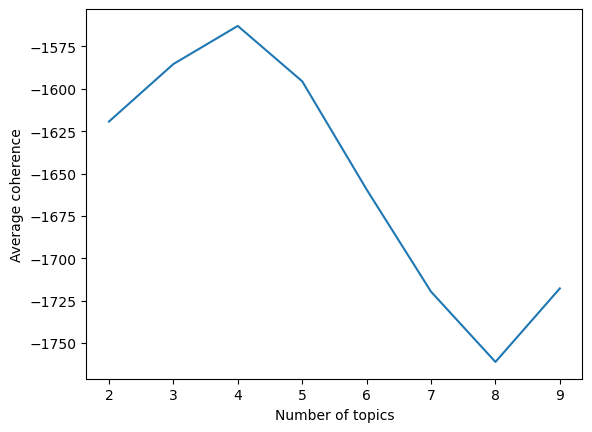

In [39]:
plt.plot(k_values, avg_coherences)
plt.xlabel('Number of topics')
plt.ylabel('Average coherence')

# For differnt number of topics, I fitted a different LDA



Text(0, 0.5, 'Average number of unique words')

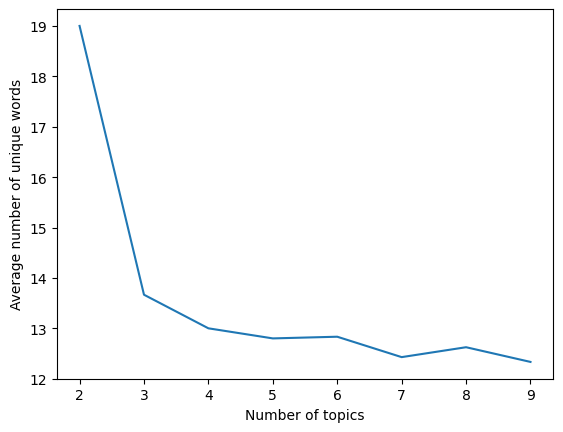

In [41]:
plt.plot(k_values, avg_num_unique_words)
plt.xlabel('Number of topics')
plt.ylabel('Average number of unique words')

# For different topic models, the average number of unique words
# We want coherence to be high and unique words to be high

# Number of topic = 2, gets me high coherence and hogh unique words. BUT, for model 2, there are 2 topics: garbage and not garbage!
# that doesnt help a lot

# So, you want to tolerate a lower value for one of the metrics, but look at the actual topics to interpret what is going on
# If we see resutlts of 4, starts to make more ssense but feels like still low
# go to 5, starts to make a bit more sense



# References
Evaluate Topic Models: Latent Dirichlet Allocation (LDA), available at https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [25]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [65]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(sample_data))

print(data_words[:1])

[['tristansnell', 'get', 'rid', 'safety', 'rule', 'get', 'get', 'rid', 'bank', 'safety', 'rule', 'get', 'svb', 'signature']]


In [66]:
data_lemmatized = data_words
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 4), (2, 2), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1)]]


In [67]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [68]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.060*"north" + 0.039*"danger" + 0.022*"accident" + 0.019*"de" + '
  '0.016*"fire" + 0.015*"show" + 0.013*"last" + 0.013*"fox" + 0.012*"many" + '
  '0.012*"mile"'),
 (1,
  '0.021*"another" + 0.020*"derails" + 0.018*"say" + 0.016*"toxic" + '
  '0.016*"report" + 0.012*"company" + 0.012*"chemical" + 0.011*"epa" + '
  '0.011*"public" + 0.010*"resident"'),
 (2,
  '0.062*"derail" + 0.037*"carolina" + 0.034*"car" + 0.029*"via" + '
  '0.020*"cargo" + 0.019*"springfield" + 0.017*"time" + 0.016*"place" + '
  '0.016*"sign" + 0.016*"news"'),
 (3,
  '0.027*"trump" + 0.024*"safety" + 0.019*"would" + 0.016*"biden" + '
  '0.015*"rule" + 0.015*"regulation" + 0.014*"rail" + 0.012*"brake" + '
  '0.012*"go" + 0.010*"apply"')]


In [69]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.359154475447044

Coherence Score:  0.36541159788559885


In [74]:
lda_model

In [71]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.341831 -0.172684       1        1  46.884871
3     -0.051284  0.366037       2        1  27.326682
2      0.218580 -0.147803       3        1  16.444026
0      0.174536 -0.045550       4        1   9.344421, topic_info=           Term          Freq         Total Category  logprob  loglift
118      derail  10784.000000  10784.000000  Default  30.0000  30.0000
2587      north   5922.000000   5922.000000  Default  29.0000  29.0000
2583   carolina   6340.000000   6340.000000  Default  28.0000  28.0000
354         car   5851.000000   5851.000000  Default  27.0000  27.0000
149       trump   7672.000000   7672.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1614         la    517.892877    518.652872   Topic4  -5.2452   2.3689
923        care    598.881806    599.767014   Topic4  -5.0999   2.3689
32       damage    511.558984    512.366706   Topic4  -5.2575   2.3688
23727        le    493.086167    493.866106   Topic4  -5.2943   2.3688
2330       axle    518.421509    519.313233   Topic4  -5.2442   2.3687

[155 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
309       4  0.999707        accident
310       4  0.998163          accord
290       2  0.999456  administration
9481      1  0.535263             amp
9481      2  0.457742             amp
...     ...       ...             ...
208       3  0.999798             via
947       2  0.999286           waste
1304      3  0.999679           wheel
359       2  0.999760           would
231       1  0.999776            year

[134 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

toxic : 0.022457791846392967
ceo : 0.01909519770061295
resident : 0.017347292501322095
chemical : 0.016160113157076755
epa : 0.013899063024322483
via : 0.009893960751737617
pay : 0.008269276069613581
say : 0.008163893554262587
senate : 0.008134594278846838
tell : 0.007605117286419225
congress : 0.006781515182579619
order : 0.006306676179334696
clean : 0.006226100852638858
rail : 0.0062106600464542985
crash : 0.006076923915123679
site : 0.005999986680991488
worker : 0.0059216764863732185
animal : 0.005689835953484064
company : 0.00549751936463235
demand : 0.005352323604188377

In [72]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [73]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

AttributeError: module 'gensim.models' has no attribute 'wrappers'

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:

# Create Corpus
# texts = data_lemmatized

# Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1][0][:30])